In [1]:
import gzip
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

# If the nltk_data directory is at the default path then comment out the line below
# otherwise set it to the desired location
nltk.data.path.append('/home/shan/Packages/nltk_data')

In [2]:
# Extract and read the input file line by line
def read_input_file(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

In [3]:
# Store the data in input file in a dataframe
def parse_input(path):
    i = 0
    df = {}
    for d in read_input_file(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
# Preprocessing the input
def preprocess_input(data):

    # Merge summary and reviewText
    data['review'] = data['summary'] + ' ' + data['reviewText']

    # Separate out upvotes and downvotes from 'helpful'
    votes = list(zip(*list(data['helpful'].values)))
    data['upvotes'] = np.array(votes[0])
    data['downvotes'] = np.array(votes[1])
    
    # Remove unnecessary features
    del data['reviewTime'], data['unixReviewTime'], data['reviewerName'], data['summary'], data['reviewText'], data['helpful']

    # Rearrange columns
    data = data[['reviewerID', 'asin', 'overall', 'upvotes', 'downvotes', 'review']]
    
    return data

In [5]:
# Filtering the dataset
def filter_input(data):
    
    # (1) Review should have atleast 5 votes
    data.drop(data[data.upvotes + data.downvotes <= 5].index, inplace=True)

    # (2) Each product should have more than 7 reviews
    product_review_count = data['asin'].value_counts()
    unpopular_products = product_review_count[product_review_count <= 7].index
    data.drop(data[data['asin'].isin(unpopular_products)].index, inplace=True)
    
    return data

In [6]:
# Textual Features
def extract_textual_features(data):
    
    # m: total number of training examples
    m = len(data['review'].values)
    
    # total number of characters
    text_length = np.array(data['review'].str.len()).reshape((m, 1))
    
    # total number of alphabetical characters
    character_count = np.array(
        data['review'].replace(regex=True, to_replace=r'[^a-zA-Z]', value=r'').str.len()
    ).reshape((m, 1))
    
    # the number of words, unique words, and sentences in the review text
    sentence_count, word_count, unique_word_count = [], [], []
    for review in data['review'].values:
        # s = sent_tokenize(review)
        # sentence_count.append(len(s))
        text_blob = TextBlob(review)
        word_count.append(len(text_blob.words))
        unique_word_count.append(len(set(text_blob.words)))
        sentence_count.append(len(text_blob.sentences))
    word_count = np.array(word_count).reshape((m, 1))
    unique_word_count = np.array(unique_word_count).reshape((m, 1))
    sentence_count = np.array(sentence_count).reshape((m, 1))
    
    # Automated Readability Index
    ARI = 4.71 * (character_count / word_count) + 0.5 * (word_count / sentence_count)
    ARI = np.reshape(ARI, (m, 1))
    
    return np.concatenate(
        (text_length, character_count, word_count, unique_word_count, sentence_count, ARI),
        axis=1
    )

In [7]:
# Metadata Features
def extract_metadata_features(data):
    
    # m: total number of training examples
    m = len(data['overall'].values)
    
    # overall rating, the user gave to the product
    rating = np.array(data['overall'].values).reshape((m, 1))
    
    return rating

In [8]:
# Create bag of words
def create_bag_of_words(data):
    
    # Construct a bag of words matrix (Considering only the top 1000 words)
    vectorizer = CountVectorizer(lowercase=True, stop_words="english", max_features=1000)
    matrix = vectorizer.fit_transform(np.array(data['review'].values))
    
    return matrix.todense()

# Bag of Words matrix
# bow = create_bag_of_words(pd.concat([df_train, df_test]))

In [9]:
# Create tf-idf representation of the review text
def create_tf_idf_vector(data):
    
    # Construct a tf-idf matrix
    vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    matrix = vectorizer.fit_transform(data['review'].values)
    
    return matrix.todense()

# tf-idf matrix
# matrix = create_tf_idf_vector(pd.concat([df_train, df_test]))

In [10]:
# Create the feature vector and the result vector
def get_xy_vectors(data):
    
    # Constructing feature vector
    X = np.concatenate(
        (extract_textual_features(data), extract_metadata_features(data)),
        axis = 1
    )
    
    # m: total number of training examples
    m = X.shape[0]
    
    # Set the outcome variable (Denotes helpfulness of a review)
    upvotes = np.array(data['upvotes'].values).reshape((m, 1))
    downvotes = np.array(data['downvotes'].values).reshape((m, 1))
    Y = upvotes / (upvotes + downvotes)
    
    return X, Y

In [11]:
# Read from input file and store the contents in a dataframe
INPUT_FILE = 'reviews_Video_Games_5.json.gz'
df = parse_input(INPUT_FILE)

In [12]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,DIRT 3,1308009600,"06 14, 2011"


In [13]:
# Remove unecessary data from the dataset
df = preprocess_input(df)
df = filter_input(df)
df.head()

,reviewerID,asin,overall,upvotes,downvotes,review
0,A2HD75EMZR8QLN,0700099867,1.0,8,12,Pay to unlock content? I don't think so. Insta...
3,A1DLMTOTHQ4AST,0700099867,3.0,7,10,"awesome game, if it did not crash frequently !..."
6,AN3YYDZAS3O1Y,0700099867,5.0,11,13,A step up from Dirt 2 and that is terrific! Lo...
18,A10AYT89XSCE46,0700099867,1.0,2,5,Colin McRae CRASH 3! This game is bug landFirs...
19,A29KT7UP7DLM1J,0700099867,1.0,3,3,The first one was much better. DiRT 2 was like...


In [14]:
# Separate data into training set and test set
df_train = df.sample(frac=0.8)
df_test = df.loc[~df.index.isin(df_train.index)]

In [15]:
# X_train: Input vector for the training set
# Y_train: Vector containing the results of the training set
X_train, Y_train = get_xy_vectors(df_train)

# X_test: Input vector for the test set
# Y_test: Vector containing the results of the test set
X_test, Y_test = get_xy_vectors(df_test)

In [16]:
# Bag of Words matrix
bow = create_bag_of_words(pd.concat([df_train, df_test]))

In [17]:
# Merge the bag of words matrix with the feature vectors
k = X_train.shape[0]

X_train1 = np.concatenate(
    (X_train, bow[:k, :]),
    axis=1
)

X_test1 = np.concatenate(
    (X_test, bow[k:, :]),
    axis=1
)

In [18]:
print('Dimensions of training set vectors:')
print('X: ', X_train1.shape)
print('Y: ', Y_train.shape)

print('\nDimensions of test set vectors:')
print('X: ', X_test1.shape)
print('Y: ', Y_test.shape)

Dimensions of training set vectors:
X:  (35012, 1007)
Y:  (35012, 1)

Dimensions of test set vectors:
X:  (8753, 1007)
Y:  (8753, 1)


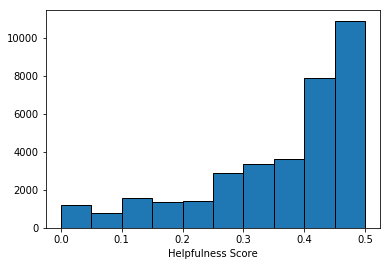

In [19]:
# Vizualizing the distribution of helpfulness score across the data
plt.hist(Y_train, ec='black')
plt.xlabel('Helpfulness Score')
plt.show()

In [20]:
linear_model = LinearRegression()
linear_model.fit(X_train1, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
Y_pred = linear_model.predict(X_test1)

In [22]:
linear_model.score(X_test1, Y_test)

0.25836404914688138